In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
batch_size=256
learning_rate=0.0002
num_epoch=10


In [3]:
mnist_train=dset.MNIST("./",train=True, transform=transforms.ToTensor(),target_transform=None,download=True)
mnist_test=dset.MNIST("./",train=False, transform=transforms.ToTensor(),target_transform=None,download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 91802930.68it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 65372743.56it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39222854.63it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24518055.04it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_loader=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

# 합성곱 오토인코더 모델 구현 학습 및 결과 확인

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(1,16,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.layer2=nn.Sequential(
         nn.Conv2d(64,128,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
         nn.Conv2d(128,256,3,padding=1),
         nn.ReLU()
    )
  def forward(self,x):
      out=self.layer1(x)
      out=self.layer2(out)
      out=out.view(batch_size,-1)
      return out

In [6]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layer1=nn.Sequential(
        nn.ConvTranspose2d(256,128,3,2,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )
    self.layer2=nn.Sequential(
         nn.ConvTranspose2d(64,16,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
         nn.ConvTranspose2d(16,1,3,2,1,1),
        nn.ReLU(),
    )
  def forward(self,x):
      out=x.view(batch_size,256,7,7)
      out=self.layer1(out)
      out=self.layer2(out)

      return out

In [7]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

encoder=Encoder().to(device)
decoder=Decoder().to(device)

parameters=list(encoder.parameters())+list(decoder.parameters())

loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(parameters,lr=learning_rate)

cuda:0


In [8]:
for i in range(num_epoch):
  for j,[image,label]in enumerate(train_loader):
    optimizer.zero_grad()
    image=image.to(device)

    output=encoder(image)
    output=decoder(output)

    loss=loss_func(output,image)
    loss.backward()
    optimizer.step()

torch.Size([256, 28, 28])


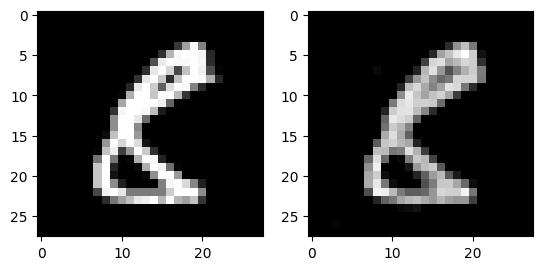

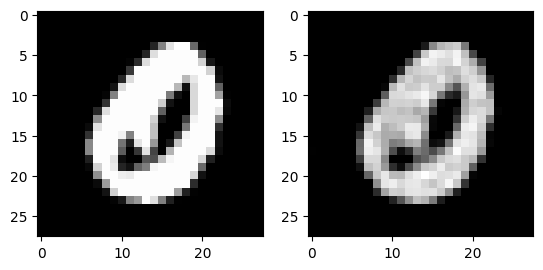

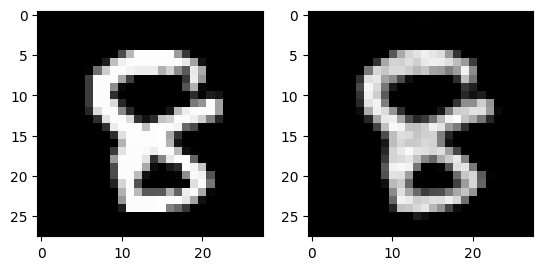

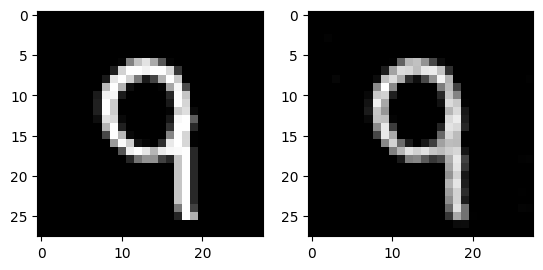

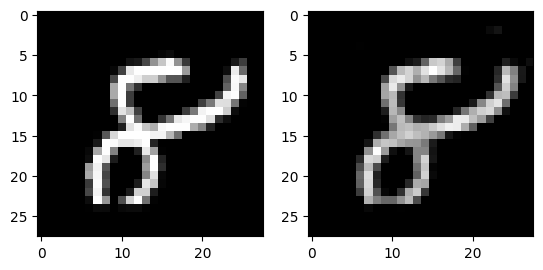

In [9]:
out_img=torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.subplot(1,2,1)
  plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()